In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:53936" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:53956, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:53957, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:53953, threads: 2>})

In [4]:
model_data = pd.read_pickle('DFs/model_data.pkl')

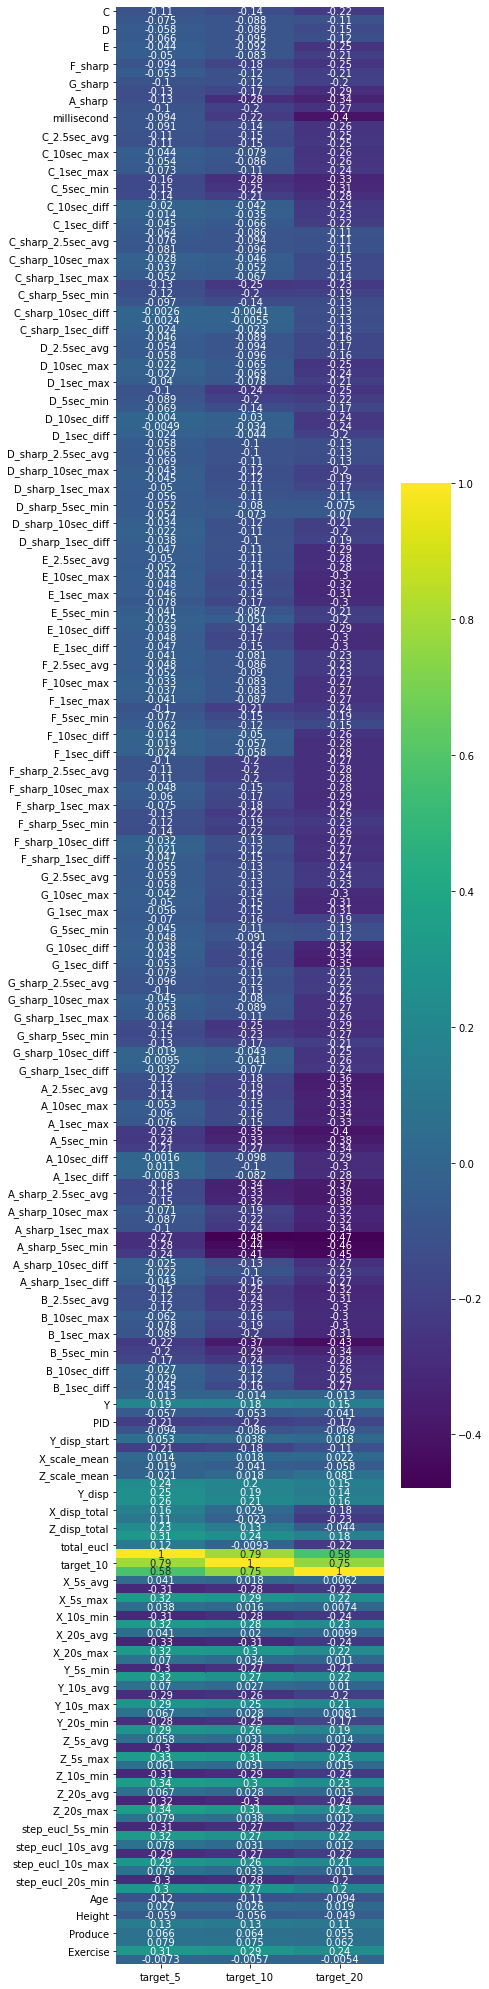

In [5]:
#Taking a look a correlations between features
corr = model_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr.loc[:,['target_5', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.savefig('correlation')
plt.show()

In [6]:
model_data['segment'].unique()

array(['silence', 'class1', 'class2', 'class3', 'class4', 'hiphop',
       'salsa', 'edm'], dtype=object)

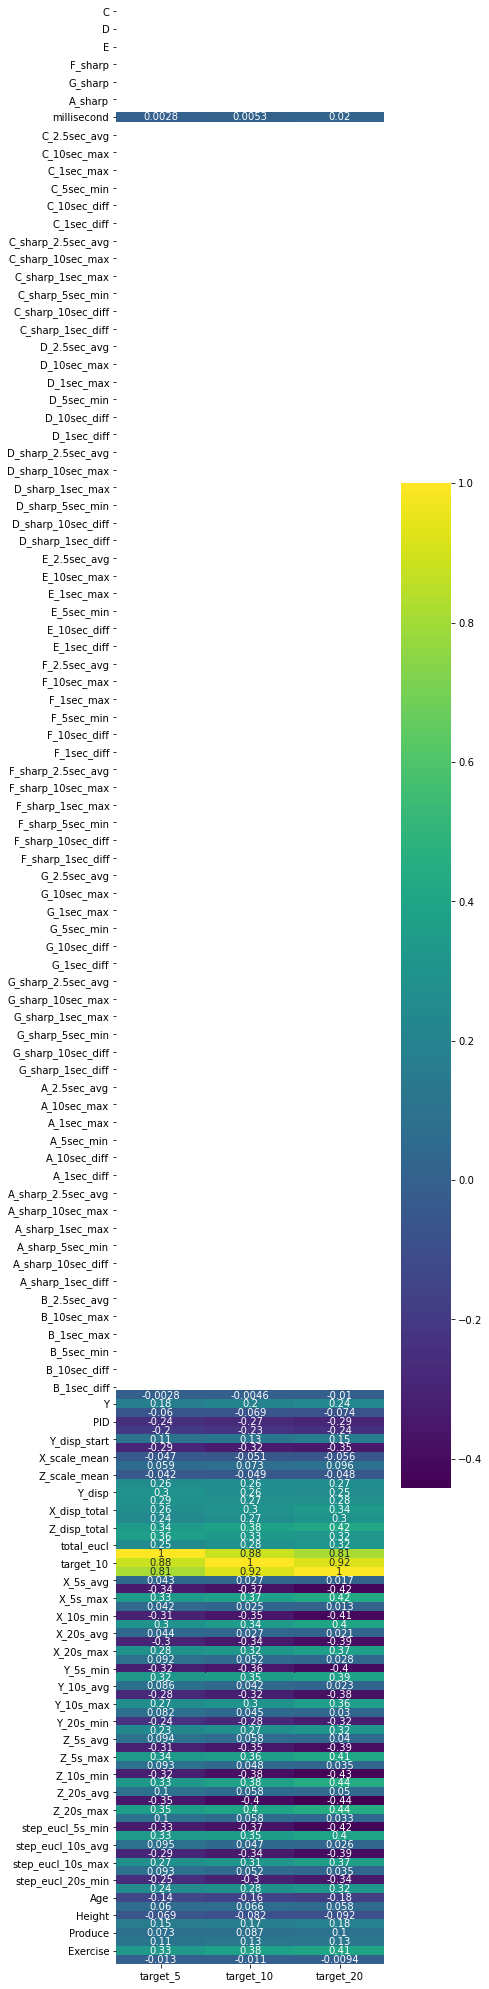

In [7]:
#Taking a look a correlations between features for silent only
silent_data = model_data.loc[model_data['segment']=='silence']
corr_sil = silent_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr_sil.loc[:,['target_5', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.show()

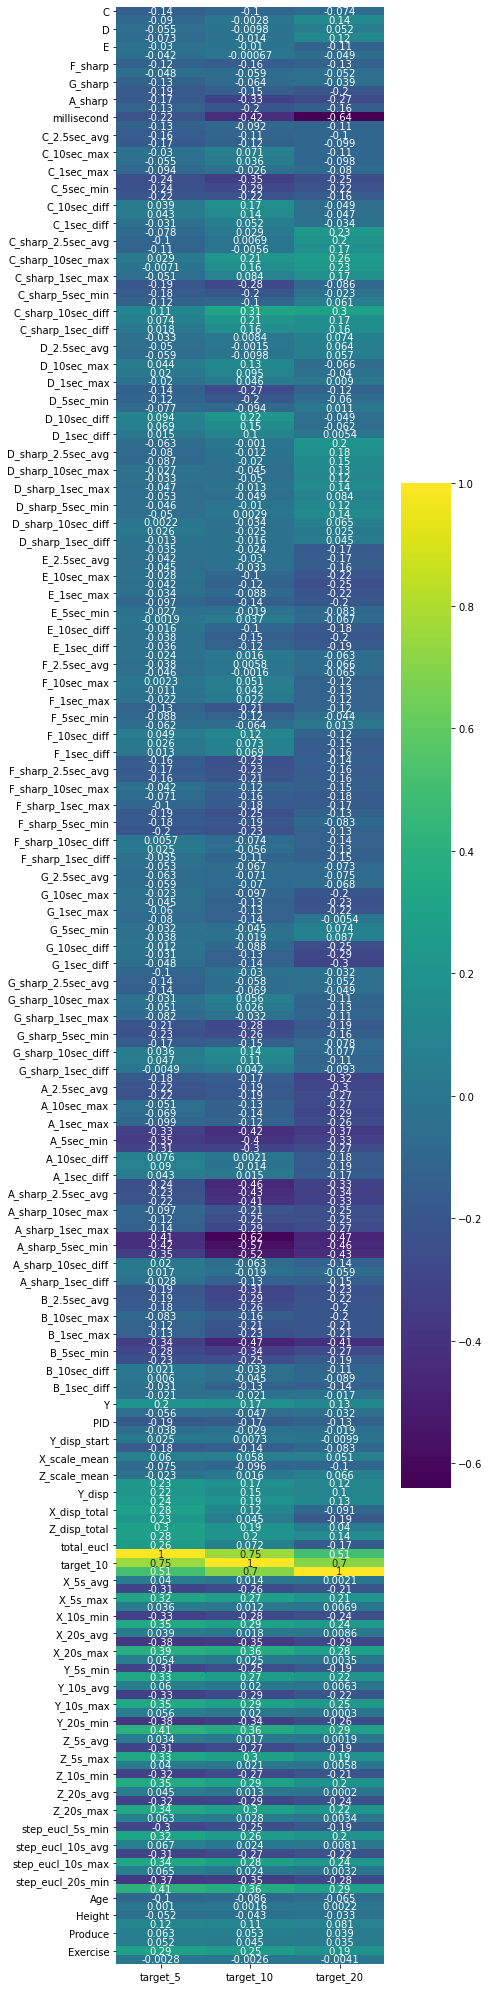

In [8]:
#Taking a look a correlations between features for non-silent only
music_data = model_data.loc[model_data['segment']!='silence']
corr_mus = music_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr_mus.loc[:,['target_5', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.show()

In [9]:
pca = PCA()
scaler = StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=['segment', 'SID', 'PID'])), 
                      columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns)
pca.fit(scaled)

PCA()

In [10]:
ex = pca.explained_variance_ratio_

In [11]:
exdf = pd.DataFrame(ex.reshape(1, -1), columns =model_data.drop(columns=['segment', 'SID', 'PID']).columns )
exdf

,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp,A,...,Age,Sex,Height,Listen,Produce,Dance,Exercise,Tiresome,age_bin,height_bin
0,0.531944,0.071326,0.030837,0.027898,0.026665,0.020288,0.015197,0.014549,0.013562,0.011312,...,3.500253e-28,2.286666e-28,1.353477e-28,4.120553e-29,2.673105e-29,1.383915e-29,1.347067e-29,6.062775e-30,4.203870e-30,1.630381e-30


In [12]:
pca10 = PCA(n_components=10)
scaled = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=['segment', 'SID', 'PID'])), 
                      columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns)
model_pca = pca.fit_transform(scaled)

In [13]:
elastic = ElasticNet()
model_pca_1 = pd.DataFrame(model_pca, columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns )#.loc[model_data['PID']== 70]
drop_cols = ['target_5', 'target_10', 'target_20', 'X', 'Y','Z']
model_pca_1i = model_pca_1.set_index('millisecond')
Xpca = model_pca_1i.drop(columns=drop_cols).to_numpy()[:125000]
ypca = model_pca_1i['target_10'].to_numpy()[:125000]

elastic.fit(Xpca[:100000], ypca[:100000])
elastic.score(Xpca[100000:], ypca[100000:])

-1.2335809359331762e-05

In [14]:
elastic_pred = pd.DataFrame(elastic.predict(Xpca[100000:]), columns=['pred'])
elastic_pred['pred'].unique()

array([0.00024292])

In [15]:
true = ypca[100000:]
true

array([-0.12172732, -0.09551044, -0.12700942, ...,  0.00904836,
        0.0271361 ,  0.0198483 ])

[]

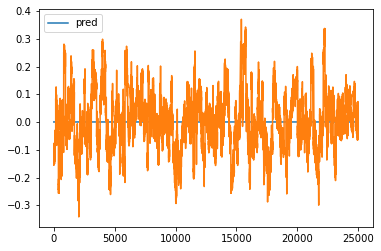

In [16]:
sns.lineplot(data=elastic_pred)
sns.lineplot(data=true)
plt.plot()

In [17]:
def cross_val_time(model, algo,  X, y, split=5):
    count=1
    tscv = TimeSeriesSplit(n_splits=split)
    scoretemp = {algo+'_MAE':[], algo+'_MSE':[], algo+'_MPE':[]}
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print(train_index[0], train_index[-1], test_index[0], test_index[-1])
        with joblib.parallel_backend('dask'):
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        #scoretemp[algo + '_R2'].append(r2_score(y_test, y_pred))
        scoretemp[algo + '_MAE'].append(mean_absolute_error(y_test, y_pred))
        scoretemp[algo + '_MSE'].append(mean_squared_error(y_test, y_pred))
        scoretemp[algo + '_MPE'].append(mean_absolute_percentage_error(y_test, y_pred))
        for i in scoretemp.keys():
            print(i + ': '+ str(scoretemp[i][count-1]))
        count+=1
    scoretemp = pd.DataFrame(scoretemp)
    return scoretemp

In [18]:
def Xy_prep(df, target, a=1, b=75):
    df_1 = df.loc[df['PID'].between(a, b)]
    drop_cols = ['PID', 'SID', 'target_5', 'target_10', 'target_20', 'X', 'Y','Z', 'segment']
    df_1i = df_1.set_index('millisecond')
    X = df_1i.drop(columns=drop_cols).to_numpy()[:125000]
    y = df_1i[target].to_numpy()[:125000]
    cols = df_1i.drop(columns=drop_cols).columns
    return X, y, cols

In [19]:
rf = RandomForestRegressor()
X, y, cols = Xy_prep(model_data, 'target_10', 60, 70)
score_rf1 = cross_val_time(model = rf, algo='RF', X=X, y=y)

0 3265 3266 6530
RF_MAE: 11.862071889536846
RF_MSE: 254.16866086454795
RF_MPE: 0.12303841073068075
0 6530 6531 9795
RF_MAE: 14.427771929821562
RF_MSE: 337.4196374197643
RF_MPE: 0.16150932179755045
0 9795 9796 13060
RF_MAE: 10.509668756874303
RF_MSE: 176.45029109694914
RF_MPE: 0.10816385536459504
0 13060 13061 16325
RF_MAE: 10.579339240870379
RF_MSE: 187.49644816127733
RF_MPE: 0.11807146081082374
0 16325 16326 19590
RF_MAE: 37.28711238174866
RF_MSE: 3015.8611061807865
RF_MPE: 1.3731358532499704e+17
